In [266]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob

In [267]:
x = []
y = []
gesture_classes = []
npy_files = glob.glob(os.path.join("data", "*.npy"))

for file in npy_files:
    filename = os.path.basename(file)
    gesture_class = filename.replace('.npy', '')
    
    data = np.load(file)
    x.extend(data)
    y.extend([gesture_class] * len(data))
    
    if gesture_class not in gesture_classes:
        gesture_classes.append(gesture_class)

x = np.array(x)
y = np.array(y)

In [268]:
print(f"Feature dimension: {x.shape[1]}")  # 18
print(f"Gesture classes: {gesture_classes}")
print(f"Class distribution:")
unique, counts = np.unique(y, return_counts=True)
for class_name, count in zip(unique, counts):
    print(f"  {class_name}: {count} samples")

Feature dimension: 18
Gesture classes: ['four', 'out']
Class distribution:
  four: 130 samples
  out: 130 samples


In [269]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(gesture_classes)

print(f"Label mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")

Label mapping:
  four: 0
  out: 1


In [270]:
x_normalized = (x - np.mean(x, axis=0)) / np.std(x, axis=0)

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x_normalized, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"normalized features: {x_normalized}")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

normalized features: [[ 0.4355823  -0.17784055  0.37099322 ... -0.40880628  2.00700042
   0.81092554]
 [ 0.7336927  -0.18824764 -0.02871985 ... -0.46421071  1.54506672
   1.32355249]
 [ 1.49249005  0.26178917  0.10182519 ... -0.43505066  0.97671604
  -0.54579903]
 ...
 [ 0.44861922 -0.73437434 -0.78849084 ... -0.56116986 -0.2145945
  -0.38463002]
 [ 0.4265376  -0.72875323 -0.89830546 ... -0.50499657  0.56237965
  -0.61076815]
 [ 0.33046836 -0.73033801 -0.70547631 ... -0.33755979  0.27412966
  -0.23008726]]
Training samples: 182
Validation samples: 39
Test samples: 39


In [271]:
model = models.Sequential([
    # First convolutional block
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(18, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    
    # Second convolutional block
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),
    
    # Dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(num_classes, activation='sigmoid')
])

c:\Users\Admin\Desktop\Project\hand-mcq-rtc\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [272]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 16, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,690 (229.26 KB)

 Trainable params: 58,306 (227.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    # ModelCheckpoint(
    #     'best_gesture_model.h5',
    #     monitor='val_accuracy',
    #     save_best_only=True,
    #     verbose=1
    # )
]

In [274]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=1,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

1/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5312 - loss: 2.1375
Epoch 1: val_accuracy improved from -inf to 0.94872, saving model to best_gesture_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6997 - loss: 1.1187 - val_accuracy: 0.9487 - val_loss: 0.5132 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


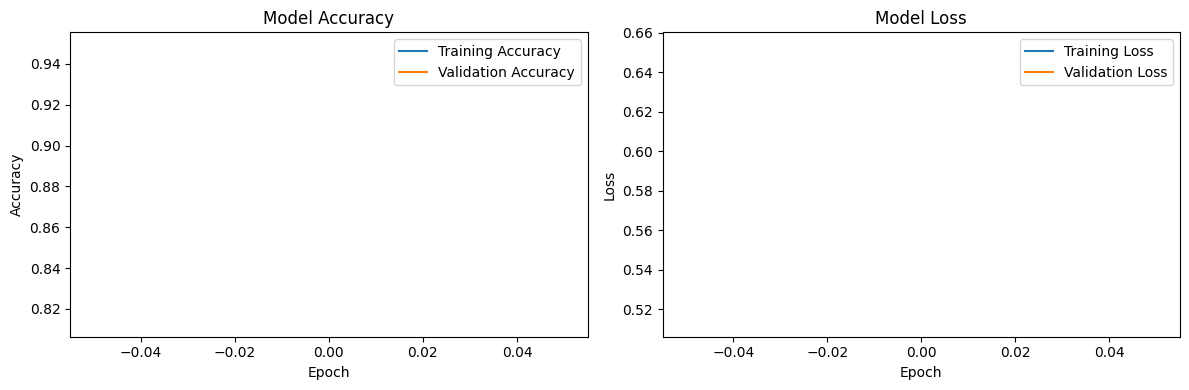

In [275]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9744
Test Loss: 0.5062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

Classification Report:
              precision    recall  f1-score   support

        four       1.00      0.95      0.97        20
         out       0.95      1.00      0.97        19

    accuracy                           0.97        39
   macro avg       0.97      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39



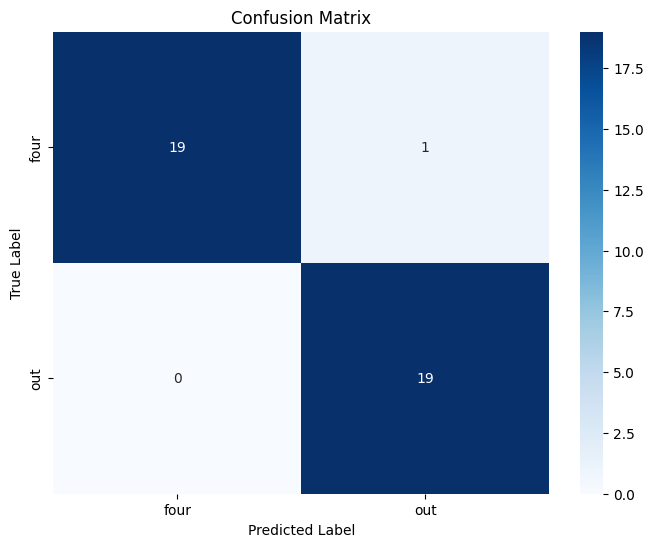

In [276]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()